In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants

In [3]:
def exact_solution(d,L, t):
    u = np.sin(np.pi*d/L)* np.cos((np.pi)**2 * t/(2*L**2))
    return u

class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh()
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation])
        self.fch = nn.Sequential(
                        *[nn.Sequential(
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

tensor(0.0120, grad_fn=<AddBackward0>)


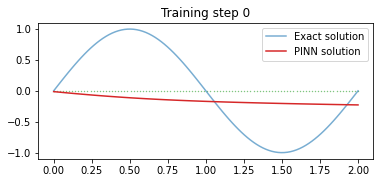

tensor(0.0065, grad_fn=<AddBackward0>)


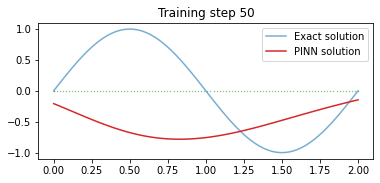

tensor(0.0040, grad_fn=<AddBackward0>)


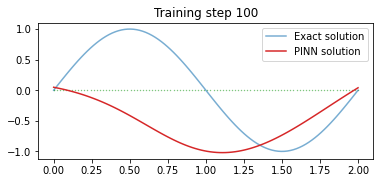

tensor(0.0019, grad_fn=<AddBackward0>)


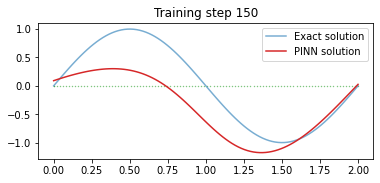

tensor(9.3952e-05, grad_fn=<AddBackward0>)


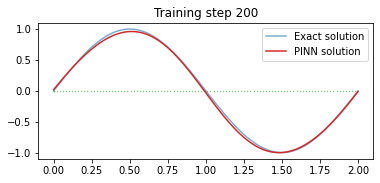

tensor(1.6582e-05, grad_fn=<AddBackward0>)


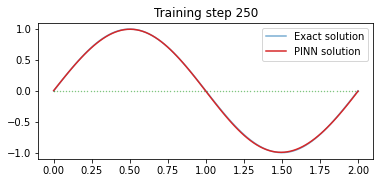

tensor(6.2050e-06, grad_fn=<AddBackward0>)


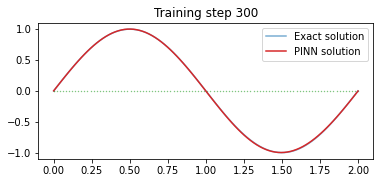

tensor(1.3248e-05, grad_fn=<AddBackward0>)


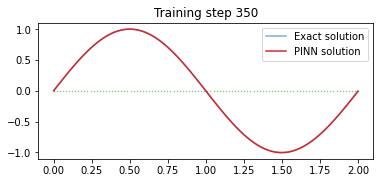

tensor(2.4194e-06, grad_fn=<AddBackward0>)


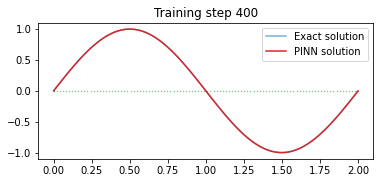

tensor(1.6855e-06, grad_fn=<AddBackward0>)


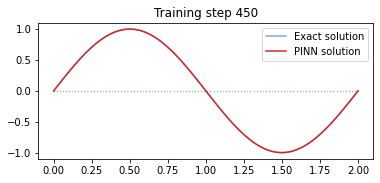

In [10]:
def psi_sol(x,L):
    psi = np.sin(2*np.pi*x/L)
    return psi

x_boundary1 = torch.tensor(0.).view(-1,1).requires_grad_(True)
x_boundary2 = torch.tensor(2.).view(-1,1).requires_grad_(True)
x_mid = torch.tensor(1.).view(-1,1).requires_grad_(True)
x_physics = torch.linspace(0,2,100).view(-1,1).requires_grad_(True)   


torch.manual_seed(123)


pinn = FCN(1,1,32,3)
L= 2
x_test = torch.linspace(0,2,100).view(-1,1)
psi_exact= psi_sol(x_test,L)

optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)
for i in range(500):
    optimiser.zero_grad()
    

    lambda1, lambda2, lambda3, lambda4 = 1e-2, 1e-4, 1e-4, 0
    

    psi = pinn(x_boundary1)
    loss1 = (torch.squeeze(psi))**2

    psi = pinn(x_boundary2)
    loss2 = (torch.squeeze(psi))**2
    
#     psi = pinn(x_mid)
#     loss6 = (torch.squeeze(psi)-1)**2

    psi = pinn(x_physics)
    dpsidx = torch.autograd.grad(psi,x_physics, 
        torch.ones_like(psi),create_graph = True,allow_unused = True)[0]
    d2psidx2 = torch.autograd.grad(dpsidx,x_physics,
            torch.ones_like(dpsidx), create_graph=True)[0]                                                                                          
    loss3 = torch.mean(((d2psidx2)+((np.pi)**2)* 4 *psi/(L**2))**2)
    Loss = (torch.trapz(psi.squeeze()**2, x_physics.squeeze())-1)**2
    
    psi = pinn(x_boundary1)
    dpsidx = torch.autograd.grad(psi,x_boundary1, 
                torch.ones_like(psi),create_graph = True,allow_unused = True)[0]
    loss4 = (torch.squeeze(dpsidx)-(2*np.pi/L))**2
    
    psi = pinn(x_boundary2)
    dpsidx = torch.autograd.grad(psi,x_boundary2, 
            torch.ones_like(psi),create_graph = True,allow_unused = True)[0]
    loss5 = (torch.squeeze(dpsidx)-(2*np.pi/L))**2
    


    loss = loss1 * lambda1 + loss2  * lambda1 + lambda2*loss3 + (loss4+ loss5)* lambda3 + Loss*lambda1
    loss.backward()
    optimiser.step()

    
    
    if i % 50 == 0: 
        print(loss)
        psi = pinn(x_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(x_physics.detach()[:,0], 
                    torch.zeros_like(x_physics)[:,0], s=2, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(x_boundary1.detach()[:,0], 
                    torch.zeros_like(x_boundary1)[:,0], s=2, lw=0, color="tab:green", alpha=0.6)
        plt.plot(x_test[:], psi_exact[:], label="Exact solution", color="tab:blue", alpha=0.6)
        plt.plot(x_test[:], psi[:], label="PINN solution", color="tab:red")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()
    